# LANGGRAPH AGENT WITH TOOLS - Building an AI Calculator

    WHAT THIS CODE DOES:
    
    Creates an AI agent that can use calculator tools to solve math problems.
    
    THE BIG IDEA:
    
    Instead of the LLM doing math itself (which it's bad at), we give it TOOLS
    to perform calculations accurately. The agent decides WHEN to use tools.
    
    EXECUTION FLOW:
    
    ┌─────────────────────────────────────────────────────────────────────────┐
    │  User: "Add 3 and 4"                                                    │
    └──────────────────────────┬──────────────────────────────────────────────┘
                               │
                               ▼
                        ┌──────────────┐
                        │  llm_call    │  "I should use the add tool"
                        │   (AI)       │  Returns: tool_call(add, 3, 4)
                        └──────┬───────┘
                               │
                               ▼
                        ┌──────────────┐
                        │  tool_node   │  Executes: add(3, 4) = 7
                        │  (execute)   │  Returns: ToolMessage("7")
                        └──────┬───────┘
                               │
                               ▼
                        ┌──────────────┐
                        │  llm_call    │  "The answer is 7"
                        │   (AI)       │  Returns: final message
                        └──────┬───────┘
                               │
                               ▼
                            ┌─────┐
                            │ END │
                            └─────┘

## STEP 1: Define Tools and Model

In [1]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model

model = init_chat_model(
    model="qwen3:8b",
    model_provider="ollama",
    temperature=0  # 0 = deterministic, no randomness
)

C:\Users\ASUS\miniconda3\envs\Ollama\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Tools

The @tool decorator converts regular Python functions into "tools" that:
1. Have structured schemas (so the LLM knows how to use them)
2. Can be called by the AI agent
3. Include docstrings that explain what they do

Think of tools as "superpowers" you give to the AI.

In [2]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.
    
    The docstring is CRITICAL - the LLM reads this to understand
    what the tool does and when to use it!
    
    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.
    
    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.
    
    Args:
        a: First int
        b: Second int
    """
    return a / b

### Augment the LLM with Tools

After binding, when you call the model, it can return TWO types of responses:
1. Regular text response: "The answer is 7"
2. Tool call request: "I need to call add(3, 4)"

In [4]:
# Create a list of all available tools
tools = [add, multiply, divide]

# Create a lookup dictionary: tool_name → tool_function
# This lets us quickly find tools by name when the LLM requests them
tools_by_name = {tool.name: tool for tool in tools}
# Example: {"add": <add_tool>, "multiply": <multiply_tool>, "divide": <divide_tool>}

# Bind tools to the model
# This tells the model: "Hey, you have these tools available to use!"
model_with_tools = model.bind_tools(tools)

## STEP 2: Define State

    Defines the STATE that flows through the agent graph.
    
    State is like a shared notebook that every node can read and write to.
    
    Attributes:
        messages: List of conversation messages (user, AI, tool results)
                  The Annotated[..., operator.add] means: when updating,
                  APPEND new messages instead of replacing them
        
        llm_calls: Counter to track how many times we've called the LLM
    
    Visual:
        State at Step 1:
        {
            "messages": [HumanMessage("Add 3 and 4")],
            "llm_calls": 0
        }
        
        State at Step 2 (after LLM call):
        {
            "messages": [
                HumanMessage("Add 3 and 4"),
                AIMessage(tool_calls=[{name: "add", args: {a:3, b:4}}])
            ],
            "llm_calls": 1
        }
        
        State at Step 3 (after tool execution):
        {
            "messages": [
                HumanMessage("Add 3 and 4"),
                AIMessage(tool_calls=[...]),
                ToolMessage(content="7")  ← Result from tool
            ],
            "llm_calls": 1
        }

In [5]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

## STEP 3: Define Model Node (The "Brain")

    NODE: Calls the LLM to decide what to do next.
    
    The LLM looks at the conversation history and decides:
    - Option A: Call a tool (e.g., "I need to use add(3, 4)")
    - Option B: Respond directly (e.g., "The answer is 7")
    
    Process Flow:
    ┌─────────────────────────────────────────────────────────┐
    │  Input State                                            │
    │  messages: [HumanMessage("Add 3 and 4")]                │
    └──────────────────────┬──────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────────────────────┐
    │  Construct Prompt                                       │
    │  SystemMessage("You are a helpful assistant...")        │
    │  + all existing messages                                │
    └──────────────────────┬──────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────────────────────┐
    │  Call model_with_tools.invoke()                         │
    │  LLM thinks: "I should use the add tool"                │
    └──────────────────────┬──────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────────────────────┐
    │  Output State                                           │
    │  messages: [AIMessage(tool_calls=[add(3,4)])]           │
    │  llm_calls: 1                                           │
    └─────────────────────────────────────────────────────────┘
    
    Args:
        state: Current state with message history
        
    Returns:
        Dictionary with:
        - New AI message (either tool call or text response)
        - Updated llm_calls counter

In [8]:
from langchain.messages import SystemMessage

def llm_call(state: dict):
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    # System message defines the AI's role/behavior
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]  # Add all conversation history
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1  # Increment counter
    }

## STEP 4: Define Tool Node (The "Hands")

    NODE: Executes the tools that the LLM requested.
    
    This node:
    1. Looks at the last AI message
    2. Extracts tool call requests
    3. Executes each tool
    4. Returns results as ToolMessages
    
    Process Flow:
    ┌─────────────────────────────────────────────────────────┐
    │  Input State                                            │
    │  Last message: AIMessage(                               │
    │      tool_calls=[{name:"add", args:{a:3,b:4}, id:"1"}]  │
    │  )                                                      │
    └──────────────────────┬──────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────────────────────┐
    │  Extract Tool Calls                                     │
    │  tool_call = {name: "add", args: {a:3, b:4}, id: "1"}   │
    └──────────────────────┬──────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────────────────────┐
    │  Look Up Tool                                           │
    │  tool = tools_by_name["add"]  → <add function>          │
    └──────────────────────┬──────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────────────────────┐
    │  Execute Tool                                           │
    │  result = add.invoke({a: 3, b: 4})  → 7                 │
    └──────────────────────┬──────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────────────────────┐
    │  Create ToolMessage                                     │
    │  ToolMessage(content="7", tool_call_id="1")             │
    └──────────────────────┬──────────────────────────────────┘
                           │
                           ▼
    ┌─────────────────────────────────────────────────────────┐
    │  Output State                                           │
    │  messages: [ToolMessage("7")]                           │
    └─────────────────────────────────────────────────────────┘
    
    Args:
        state: Current state (must contain AI message with tool_calls)
        
    Returns:
        Dictionary with ToolMessage results

In [9]:
from langchain.messages import ToolMessage

def tool_node(state: dict):
    result = []
    
    # Get all tool calls from the last AI message
    for tool_call in state["messages"][-1].tool_calls:
        # Look up the tool function by name
        tool = tools_by_name[tool_call["name"]]
        
        # Execute the tool with the provided arguments
        observation = tool.invoke(tool_call["args"])
        
        # Create a ToolMessage with the result
        # The tool_call_id links this result back to the request
        result.append(
            ToolMessage(
                content=str(observation),  # The actual result (e.g., "7")
                tool_call_id=tool_call["id"]  # Links to the original request
            )
        )
    
    return {"messages": result}

## STEP 5: Define Logic to Determine Whether to End

    CONDITIONAL EDGE: Decides where to route next based on state.
    
    This is like a traffic controller that looks at the last message and decides:
    - If AI wants to use a tool → go to "tool_node"
    - If AI has the final answer → go to END
    
    Decision Tree:
                    ┌──────────────────┐
                    │  should_continue │
                    └────────┬─────────┘
                             │
                ┌────────────┴────────────┐
                │                         │
                ▼                         ▼
    ┌─────────────────────┐   ┌─────────────────────┐
    │ Has tool_calls?     │   │ No tool_calls?      │
    │ YES                 │   │ NO                  │
    └──────┬──────────────┘   └──────┬──────────────┘
           │                         │
           ▼                         ▼
    ┌─────────────┐          ┌─────────────┐
    │ "tool_node" │          │     END     │
    └─────────────┘          └─────────────┘
    
    Args:
        state: Current state with messages
        
    Returns:
        "tool_node" if AI wants to use a tool
        END if AI has final answer

In [10]:
from typing import Literal
from langgraph.graph import StateGraph, START, END

def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if the LLM made a tool call
    # AIMessage has a .tool_calls attribute that's either:
    # - Empty list [] if no tools requested
    # - List of tool calls if tools requested
    if last_message.tool_calls:
        return "tool_node"  # Execute the tools
    
    # Otherwise, the AI has provided a final text response
    return END  # Stop and return to user

## STEP 6: Build the Agent Graph

    GRAPH STRUCTURE:
    
             START
               │
               ▼
          ┌─────────┐
          │llm_call │ ◄─────────┐
          └────┬────┘           │
               │                │
          [should_continue?]    │
               │                │
          ┌────┴────┐           │
          ▼         ▼           │
      tool_node    END          │
          │                     │
          └─────────────────────┘
    
    EXECUTION TRACE (for "Add 3 and 4"):
    1. START → llm_call
       - AI: "I'll use add(3, 4)"
       
    2. llm_call → should_continue → tool_node
       - Tool: add(3, 4) = 7
       
    3. tool_node → llm_call
       - AI: "The answer is 7"
       
    4. llm_call → should_continue → END
       - Done!

In [17]:
# Initialize the graph builder
agent_builder = StateGraph(MessagesState)

### Add Nodes (The Processing Units)

In [18]:
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

### Add Edges (The Connections)

In [19]:
# Always start at llm_call
agent_builder.add_edge(START, "llm_call")

# After llm_call, use should_continue to decide where to go
# This is a CONDITIONAL edge - it can go to different places
agent_builder.add_conditional_edges(
    "llm_call",           # From this node
    should_continue,      # Use this function to decide
    ["tool_node", END]    # Possible destinations
)

# After tool_node, always go back to llm_call
# This creates a LOOP that allows multiple tool calls
agent_builder.add_edge("tool_node", "llm_call")

### Compile the Agent

    Compilation turns the blueprint into an executable agent.
    Now we can invoke() it with messages!

In [20]:
agent = agent_builder.compile()

## STEP 7: Visualize and Run the Agent

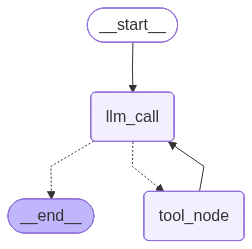

In [21]:
# Visualize the graph (optional - requires IPython)
try:
    from IPython.display import Image, display
    display(Image(agent.get_graph(xray=True).draw_mermaid_png()))
except:
    print("(Skipping visualization - not in Jupyter)")

## Run the Agent

In [22]:
from langchain.messages import HumanMessage

print("\n" + "=" * 70)
print("RUNNING AGENT: Add 3 and 4, then multiply by 2")
print("=" * 70)

# Create initial message
messages = [HumanMessage(content="Add 3 and 4, then multiply by 2.")]

# Invoke the agent
# This runs the entire graph until it reaches END
result = agent.invoke({"messages": messages})

print("\n[Agent Execution Trace]")
print("-" * 70)

# Print all messages in the conversation
for i, m in enumerate(result["messages"], 1):
    print(f"\nMessage {i}:")
    m.pretty_print()

print("\n" + "=" * 70)
print(f"Total LLM calls: {result.get('llm_calls', 'N/A')}")
print("=" * 70)


RUNNING AGENT: Add 3 and 4, then multiply by 2

[Agent Execution Trace]
----------------------------------------------------------------------

Message 1:
================================ Human Message =================================

Add 3 and 4, then multiply by 2.

Message 2:
================================== Ai Message ==================================

<think>
Okay, the user wants to add 3 and 4 first. Let me check the available functions. There's an add function that takes two integers. So I'll call add with a=3 and b=4. That gives 7. Then they want to multiply the result by 2. The multiply function takes two integers, so I'll use that with a=7 and b=2. Wait, but do I need to store the intermediate result? Since the functions are called sequentially, each step's output is the input for the next. So first call add(3,4), then multiply the result by 2. The tools don't have a way to chain operations, so I need to handle each step separately. Let me make sure I'm using the correc